In [1]:
import numpy as np
import matplotlib as mpl
from matplotlib import pyplot as plt
import h5py
import sys
sys.path.insert(0, '../')

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import importlib

In [4]:
from glob import glob
import config

In [26]:
# files_bkg = glob(files_loc+'*Muon*bkgr*70000.0*.h5')
##files_sig = glob('/gpfs/slac/atlas/fs1/u/rafaeltl/Muon/Apr2022/si-mu-lator/batch_slac/out_files/bkgr_1/*WithMuon*.h5')
##files_bkg = glob('/gpfs/slac/atlas/fs1/u/rafaeltl/Muon/Apr2022/si-mu-lator/batch_slac/out_files/bkgr_1_override_4/*NoMuon*.h5')
##all_files = files_sig +files_bkg

#files_loc = "/home/crucible/work/muon_ml/"

#SIM=f"{config.SIM}/atlas_mdt_bkgr_{config.BKGR}"
#SIG_LOC=f"{SIM}/WithMuon*.h5"
SIG_LOC=f"./WithMuon*.h5"
files_sig = glob(SIG_LOC)


In [27]:
from algorithms import datatools
importlib.reload(datatools)

<module 'algorithms.datatools' from '../algorithms/datatools.py'>

In [28]:
data, dmat, Y, Y_mu, Y_hit, sig_keys = datatools.make_data_matrix(files_sig, max_files=1, sort_by='z')

100%|██████████| 2500/2500 [00:00<00:00, 56534.63it/s]

~~ Reading data... ~~
~~ Calculating occupancy information... ~~
!!
I read 2500 events, of which 2500 have muon and 0 do not
!!


In [29]:
data.keys()

dict_keys(['ev_mu_phi', 'ev_mu_theta', 'ev_mu_time', 'ev_mu_x', 'ev_mu_y', 'ev_n_mu_signals', 'ev_n_signals', 'ev_n_noise', 'n_sig_mmx', 'n_sig_mmu', 'n_sig_mmv', 'n_sig_mm', 'n_sig_stgc', 'n_sig_mdt'])

In [30]:
sig_keys, len( sig_keys )

(['is_muon',
  'x',
  'y',
  'z',
  'ptype',
  'ptilt',
  'poffset',
  'time',
  'projX_at_rightend_x',
  'projX_at_rightend_y',
  'projX_at_middle_x',
  'projX_at_middle_y',
  'projY_at_topend_x',
  'projY_at_topend_y',
  'projY_at_middle_x',
  'projY_at_middle_y',
  'seg_ix',
  'rdrift'],
 18)

In [31]:
data['n_sig_mdt'], data['ev_n_signals'], data['ev_mu_phi']

(array([15., 16., 12., ..., 13., 12., 23.]),
 array([15, 16, 12, ..., 13, 12, 23]),
 array([0, 0, 0, ..., 0, 0, 0]))

In [32]:
dmat[1][0].shape

(18,)

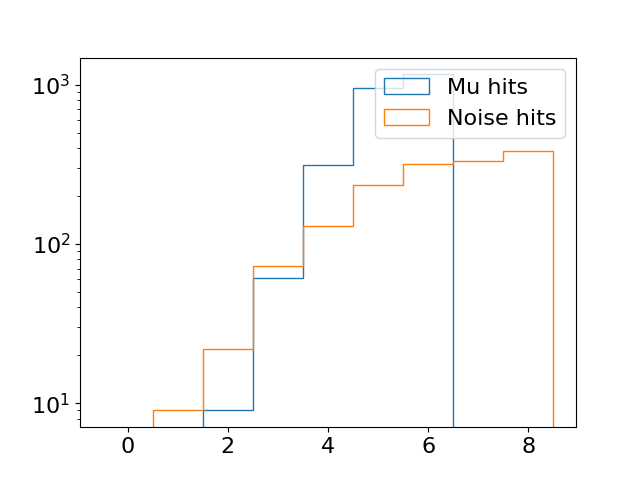

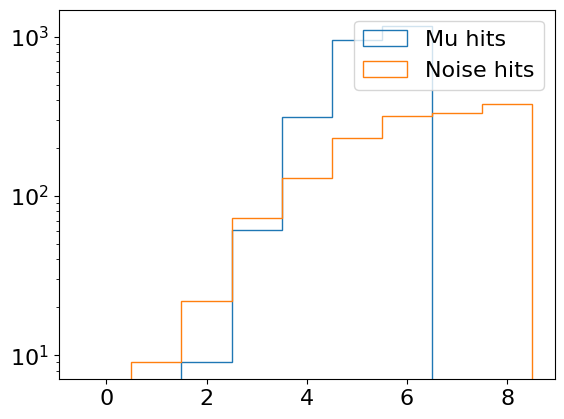

In [33]:
plt.Figure()
plt.hist(data['ev_n_mu_signals'], histtype='step', bins=9, range=(-0.5,8.5), label='Mu hits')
plt.hist(data['ev_n_signals'] - data['ev_n_mu_signals'], histtype='step', bins=9, range=(-0.5,8.5), label='Noise hits')
##plt.hist(data['ev_n_signals'][Y_mu==1], histtype='step', bins=9, range=(0,9), label='Total hits')
##plt.hist(data['ev_n_signals'][Y_mu==1], histtype='step', bins=9, range=(0,9), label='Total hits')
plt.legend(loc='upper right')
plt.yscale('log')
plt.show()

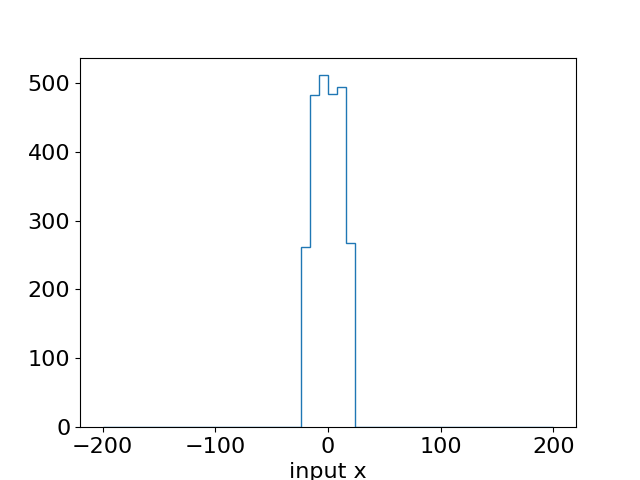

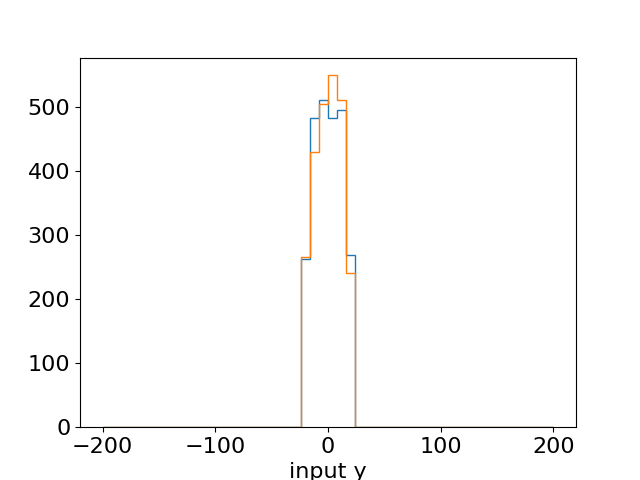

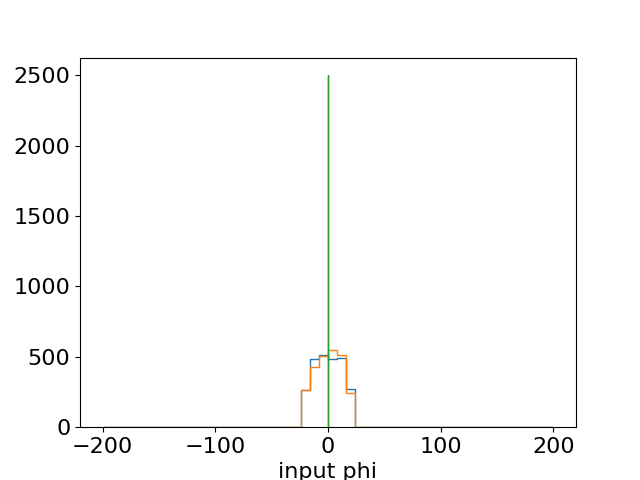

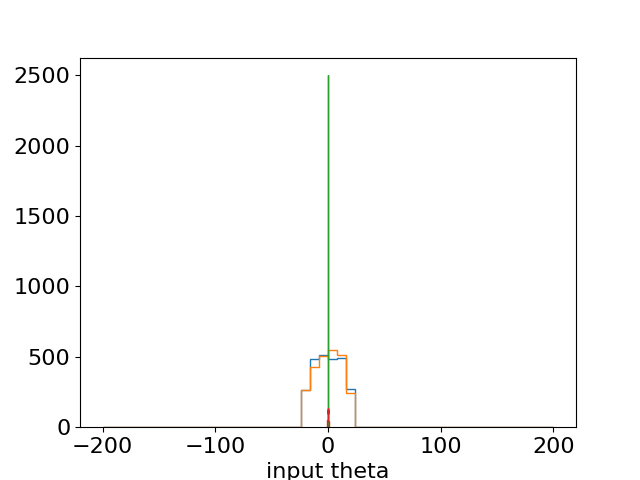

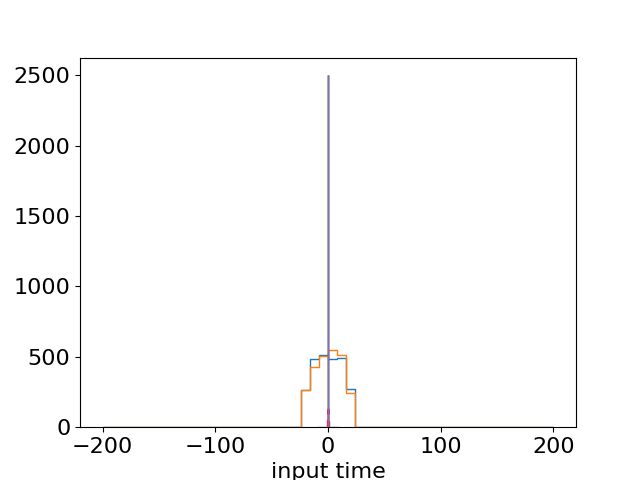

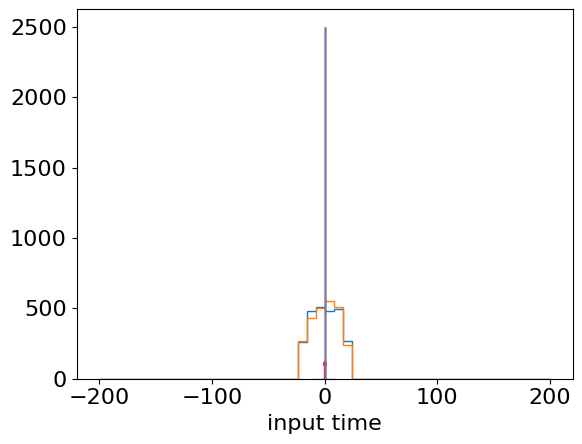

In [34]:
plt.Figure()
plt.hist(data['ev_mu_x'], histtype='step', bins=50, range=(-200, 200) )
plt.xlabel('input x')
plt.show()
plt.Figure()
plt.hist(data['ev_mu_y'], histtype='step', bins=50, range=(-200, 200) )
plt.xlabel('input y')
plt.show()
plt.Figure()
plt.hist(data['ev_mu_phi'], histtype='step', bins=50, range=(-1, 1) )
plt.xlabel('input phi')
plt.show()
plt.Figure()
plt.hist(data['ev_mu_theta'], histtype='step', bins=50, range=(-1, 1) )
plt.xlabel('input theta')
plt.show()
plt.Figure()
plt.hist(data['ev_mu_time'], histtype='step', bins=50, range=(-10, 10) )
plt.xlabel('input time')
plt.show()

In [35]:
from algorithms import linefit
importlib.reload(linefit)
from iminuit import Minuit
import math

In [36]:
def mdtSegmentT0Fcn( ang, b, t0 ):
    cosin = math.cos(ang)
    sinus = math.sin(ang)
    fval = 0.0;
    for ihit, hit in enumerate( fitdata ):       
        z = fitdata[ sig_keys.indx('z')]
        x = fitdata[ sig_keys.indx('y')]
        r = fitdata[ sig_keys.indx('rdrift')]
        # t = fitdata[ sig_keys.indx('time')] - t0
        dist = abs( b*cosin + z*sinus - x*cosin)
        fval += (dist - r)*(dist - r)
    return fval;

In [37]:
def make_fit_data( hits, sig_keys ):
    hit_types = hits[:, sig_keys.index('is_muon')]
    #valid_hits = hit_types > -90 # this contains muons + background
    valid_hits = hit_types > 0 # this contains only muons
#    print (valid_hits)
    if valid_hits.sum() < 2:
        return None
    ptype = hits[:, sig_keys.index('ptype')]
    indx_hit = (valid_hits == 1)
#    print (indx_hit)
#    print (hits[indx_hit])
    return hits[indx_hit].copy()


In [38]:
# Function to calculate line parameters (slope and intercept)
def get_mdt_line_lsq(fitdata, sigkeys ):

    zs = fitdata[:, sig_keys.index('z')]
    xs = fitdata[:, sig_keys.index('x')]
    # rs = fitdata[:, sig_keys.index('rdrift')] 
    n = len( xs )
    
    # Calculate sum of various combinations of data points and uncertainties
    Sx = np.sum(xs)
    Sz = np.sum(zs)
    Sxx = np.sum(xs ** 2)
    Szz = np.sum(zs ** 2)
    Sxz = np.sum(xs * zs)
    # Srr = np.sum(radii ** 2)

    # Calculate line parameters
    m = ((n * Sxz) - (Sx * Sz) ) / ((n * Sxx) - (Sx**2))
    c = (Sz - m * Sx) / n

    # ds = np.abs(zs - m * xs - c) - rs
    # chi2 = np.sum(ds ** 2)
    
    return [ c, m, 0 ]


In [39]:
def get_mdt_fits_lsq(events, sig_keys, overwrite=False, is_perfect=False, only_x=False):
    fits = np.zeros( (events.shape[0], 3) )
    for iev,hits in enumerate(events):
        lfit = get_mdt_line_lsq(hits, sig_keys)
        fits[iev,:] = lfit
        # if iev > 10: break
    return fits

In [40]:
def get_mdt_fits(events, sig_keys, overwrite=False, is_perfect=False, only_x=False):
    fits = np.zeros( (events.shape[0], 2) )
    verbose = False
    for iev,hits in enumerate(events):
        fitdata = make_fit_data( hits, sig_keys )
        #print(fitdata.shape, fitdata)
        def radius_dist( m, b ):
            nonlocal fitdata
            nonlocal verbose
            #grad = math.tan( ang  )
            fval = 0.0;
            for ihit, hit in enumerate( fitdata ):       
                z = hit[ sig_keys.index('z')]
                x = -hit[ sig_keys.index('projX_at_middle_x')] #- hit[ sig_keys.index('x')]
                r = hit[ sig_keys.index('rdrift')]
                dist = abs ( ( m*z - x + 1*b)/math.sqrt( 1 + m**2 ) ) 
                fval += (dist - r)*(dist - r)
                if verbose:
                    print("z, x, m, dist, r: ", [z, x, m , dist, r])
            return fval;

        mfit = Minuit( radius_dist, m=0, b=0 )
        mfit.migrad()
        fits[ iev, : ] = mfit.values[:]
        if (iev % 10 == 0 ):
            print(mfit)
        if mfit.fval > 1:
            print ("WARNING: Fit on event: ", iev, " returned fval: ", mfit.fval, mfit.values[:] )
            #verbose = True
            #radius_dist( mfit.values[0], mfit.values[1] )
            #verbose = False
            print ("retry changing init value")
            mfit = Minuit( radius_dist, m=2*mfit.values[0], b=0 )
            mfit.migrad()
            fits[ iev, : ] = mfit.values[:]
            #verbose = True
            #radius_dist( mfit.values[0], mfit.values[1] )
            #verbose = False  
            print ("New Fit returned fval: ", mfit.fval, mfit.values[:] )
            if mfit.fval > 1:
                print ("WARNING: New fit returned fval: ", mfit.fval, " there are multiple minimums" )
    return fits
	

In [41]:
import sys
import random
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import h5py
from mpl_toolkits import mplot3d
from glob import glob
from copy import deepcopy
sys.path.insert(0, '../')
from detmodel import detector
from detmodel import plane
from detmodel import signal
from detmodel.muon import Muon
from plotting import plotting
my_detector = detector.Detector()
my_detector.read_card('../cards/atlas_mdt.yml')
# fit_detector = detector.Detector()
# fit_detector.read_card('../cards/atlas_mdt.yml')
import importlib
importlib.reload(plotting)
%matplotlib widget

-- Initializing detector --
-- Reading card --


In [42]:
# how many events to fit
N_FITS = 10

In [43]:
#print (dmat[0:N_FITS].shape, dmat[0:N_FITS])
lfits = get_mdt_fits(dmat[0:N_FITS], sig_keys)
#lfits.shape

#print (lfits)

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 2.549e-11                  │              Nfcn = 60               │
│ EDM = 2.55e-11 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No Parameters at limit        │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬──────

Real Muon:  8 [-16.481565505769005, 17.43728970142312, -0.3753455592008625, 0, 0]
Fit params:  [0.4243400493519369, 8.066704177280513, 0.4243400493519369, -8.066704177280513]
Fit Muon:  [-8.066704177280513, 0, -0.4013115305321586, 0, 0]


Text(0.5, 1.0, 'Truth')

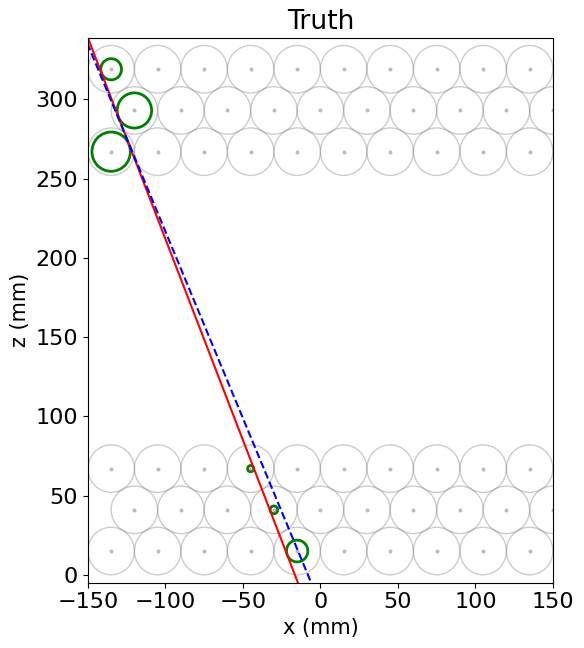

In [44]:
plt.close()
ev_idx = 8#random.randint( 0, N_FITS - 1 ) 
sig_muon = Muon( 
    data['ev_mu_x'][ev_idx], data['ev_mu_y'][ev_idx], 
    data['ev_mu_theta'][ev_idx], data['ev_mu_phi'][ev_idx], 
    data['ev_mu_time'][ev_idx] )
my_detector.reset_planes()
my_detector.add_muon( sig_muon.org_x, sig_muon.org_y, sig_muon.theta, sig_muon.phi, sig_muon.time)
print( "Real Muon: ", ev_idx, [sig_muon.org_x, sig_muon.org_y, sig_muon.theta, sig_muon.phi, sig_muon.time] )



m = lfits[ev_idx,0]
#xint = -zint/m
xint =  -1*lfits[ev_idx,1]
print("Fit params: ", [lfits[ev_idx,0], lfits[ev_idx,1], m, xint])
#fit_muon = Muon(xint, 0, -lfits[ev_idx,0]  , 0 )
fit_muon = Muon(xint, 0, -math.atan(lfits[ev_idx,0])  , 0 )
my_detector.reset_fits()
my_detector.add_fit_muon( fit_muon )
print( "Fit Muon: ",[fit_muon.org_x, fit_muon.org_y, fit_muon.theta, fit_muon.phi, fit_muon.time] )

#plt.Figure()
fig3 = plt.figure(figsize=(6,6*1.18))
ax3 = plt.axes()
plotting.plot_det_xz(my_detector, ax3, draw_muon=True, draw_allhits=False, draw_fit_muon=True)
plt.rc('font', size=16)
plt.title("Truth")
#plt.savefig('viewxz_signalhits_mdt.png')
#plt.show()

# plt.Figure()
# fig4 = plt.figure(figsize=(6,6*1.18))
# ax4 = plt.axes()
# plotting.plot_det_xz(fit_detector, ax4, draw_muon=True )
# plt.rc('font', size=16)
# plt.title("Fit")
# #plt.savefig('viewxz_signalhits_mdt.png')
# plt.show()

# hey, I presume you will implement few more changes on the above part, so not trying to fix what I broke below by the moment

In [99]:
data['ev_n_mu_signals']==6

array([ True,  True, False, ...,  True,  True, False])

In [175]:
plt.figure(figsize=(8,6))
plt.hist( lfits[:,0][(data['ev_n_signals']>1)&(Y_mu==0)], histtype='step', bins=50, range=(-0.5, 0.5), label='No mu' )
plt.hist( lfits[:,0][Y_mu==1], histtype='step', bins=100, range=(-0.5, 0.5),label='mu' )
plt.xlabel(r'Incoming Muon $\theta$')
plt.legend()
plt.show()

plt.figure(figsize=(8,6))
nhts = 6
v = lfits[:,0][(data['ev_n_mu_signals']==nhts)]
plt.hist( v, histtype='step',density=1, bins=50, range=(-0.5, 0.5),label=f'#mu hits = {nhts} (std = {v.std():.2E})' )
nhts = 5
v = lfits[:,0][(data['ev_n_mu_signals']==nhts)]
plt.hist( v, histtype='step',density=1, bins=50, range=(-0.5, 0.5),label=f'#mu hits = {nhts} (std = {v.std():.2E})' )
nhts = 4
v = lfits[:,0][(data['ev_n_mu_signals']==nhts)]
plt.hist( v, histtype='step',density=1, bins=50, range=(-0.5, 0.5),label=f'#mu hits = {nhts} (std = {v.std():.2E})' )
plt.xlabel(r'Reconstructed Incoming Muon $\theta$')
plt.legend()
plt.show()

plt.figure(figsize=(8,6))
delta = lfits[:,1] - data['ev_mu_theta']
plt.hist( v, histtype='step',density=1, bins=50, range=(-0.001, 0.001),label=f'(std = {v.std():.2E})' )
plt.xlabel(r'$\Delta$$\theta$')
plt.legend()
plt.show()
print( delta.shape )

IndexError: boolean index did not match indexed array along dimension 0; dimension is 10 but corresponding boolean dimension is 2500

<Figure size 800x600 with 0 Axes>

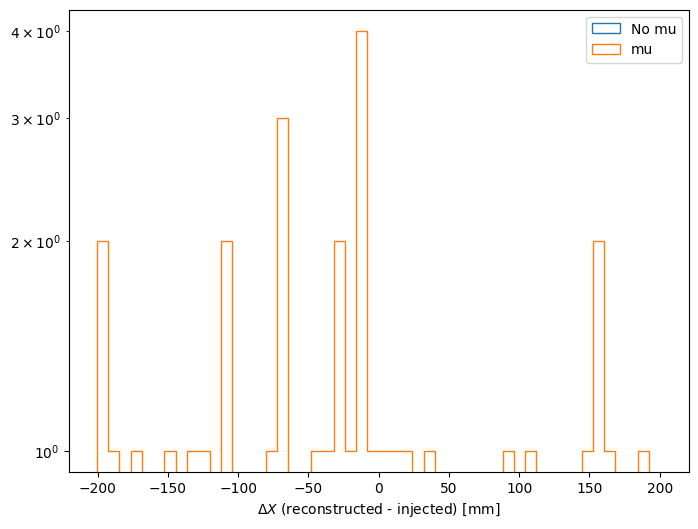

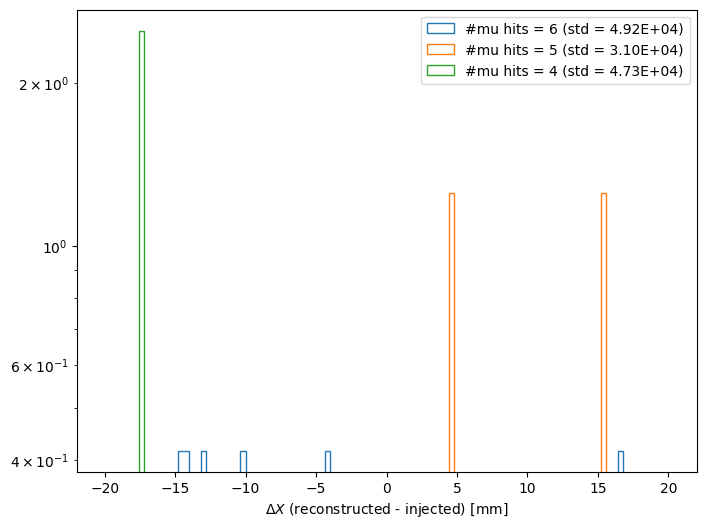

In [154]:
plt.figure(figsize=(8,6))
plt.hist( lfits[:,1][(data['ev_n_signals']>1)&(Y_mu==0)] - data['ev_mu_x'][(data['ev_n_signals']>1)&(Y_mu==0)], histtype='step', bins=50, range=(-200.5, 200.5), label='No mu' )
plt.hist( lfits[:,1][Y_mu==1] - data['ev_mu_x'][Y_mu==1], histtype='step', bins=50, range=(-200.5, 200.5), label='mu' )
plt.legend()
plt.yscale('log')
plt.xlabel(r'$\Delta X$ (reconstructed - injected) [mm]')
plt.show()

plt.figure(figsize=(8,6))
nhts = 8
rng=(-20,20)
bns=100

# v = lfits[:,1][(data['ev_n_mu_signals']==nhts)] - data['ev_mu_x'][(data['ev_n_mu_signals']==nhts)]
# plt.hist( v, histtype='step',density=1, bins=bns, range=rng,label=f'#mu hits = {nhts} (std = {v.std():.2E})' )

# nhts = 7
# v = lfits[:,1][(data['ev_n_mu_signals']==nhts)] - data['ev_mu_x'][(data['ev_n_mu_signals']==nhts)]
# plt.hist( v, histtype='step',density=1, bins=bns, range=rng,label=f'#mu hits = {nhts} (std = {v.std():.2E})' )

nhts = 6
v = lfits[:,1][(data['ev_n_mu_signals']==nhts)] - data['ev_mu_x'][(data['ev_n_mu_signals']==nhts)]
plt.hist( v, histtype='step',density=1, bins=bns, range=rng,label=f'#mu hits = {nhts} (std = {v.std():.2E})' )

nhts = 5
v = lfits[:,1][(data['ev_n_mu_signals']==nhts)] - data['ev_mu_x'][(data['ev_n_mu_signals']==nhts)]
plt.hist( v, histtype='step',density=1, bins=bns, range=rng,label=f'#mu hits = {nhts} (std = {v.std():.2E})' )

nhts = 4
v = lfits[:,1][(data['ev_n_mu_signals']==nhts)] - data['ev_mu_x'][(data['ev_n_mu_signals']==nhts)]
plt.hist( v, histtype='step',density=1, bins=bns, range=rng,label=f'#mu hits = {nhts} (std = {v.std():.2E})' )

plt.legend()
plt.yscale('log')
plt.xlabel(r'$\Delta X$ (reconstructed - injected) [mm]')

plt.show()

In [155]:
(lfits[:,1][(data['ev_n_mu_signals']==6)] - data['ev_mu_x'][(data['ev_n_mu_signals']==6)]).std()

49228.050912616985

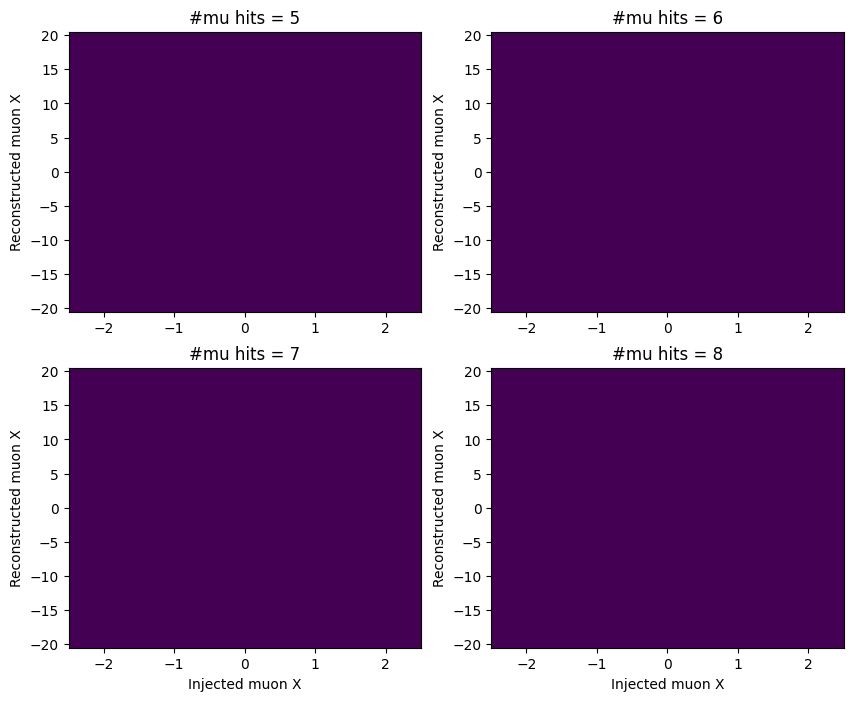

In [156]:
ncols=2
nrows=2
fig, axs = plt.subplots(ncols=ncols, nrows=nrows, figsize=(5*ncols,4*nrows))
axs = axs.flatten()

for nht in range(5, 9):
    axs[nht-5].hist2d( data['ev_mu_x'][(data['ev_n_mu_signals']==nht)], 
                      lfits[:,1][(data['ev_n_mu_signals']==nht)], bins=(50,50), range=((-2.5,2.5), (-20.5,20.5)),
                     norm=mpl.colors.LogNorm())
    if nht>6: axs[nht-5].set_xlabel('Injected muon X')
    axs[nht-5].set_ylabel('Reconstructed muon X')
    axs[nht-5].set_title(f'#mu hits = {nht}')

plt.show()

In [77]:
plt.Figure()
# plt.hist( (lfits[:,2][Y_mu==0]), histtype='step', bins=50, range=(0, 0.02), label='No mu' )
plt.hist( np.log(lfits[:,2][Y_mu==1]+1e-10), histtype='step', bins=50, range=(-11,10), label='mu' )
# plt.yscale('log')
plt.legend()
plt.show()

IndexError: index 2 is out of bounds for axis 1 with size 2

/home/crucible/work/muon_ml/rr_simu/venv/lib/python3.11/site-packages/numpy/core/_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/crucible/work/muon_ml/rr_simu/venv/lib/python3.11/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/home/crucible/work/muon_ml/rr_simu/venv/lib/python3.11/site-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/crucible/work/muon_ml/rr_simu/venv/lib/python3.11/site-packages/numpy/lib/histograms.py:885: RuntimeWarning: divide by zero encountered in divide
  return n/db/n.sum(), bin_edges


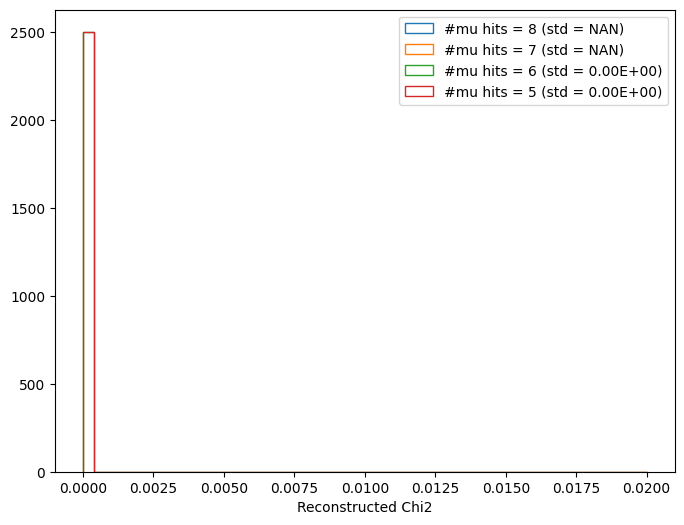

In [60]:
plt.figure(figsize=(8,6))
nhts = 8
v = lfits[:,2][(data['ev_n_mu_signals']==nhts)]
plt.hist( v, histtype='step',density=1, bins=50, range=(0, 0.02),label=f'#mu hits = {nhts} (std = {v.std():.2E})' )

nhts = 7
v = lfits[:,2][(data['ev_n_mu_signals']==nhts)]
plt.hist( v, histtype='step',density=1, bins=50, range=(0, 0.02),label=f'#mu hits = {nhts} (std = {v.std():.2E})' )

nhts = 6
v = lfits[:,2][(data['ev_n_mu_signals']==nhts)]
plt.hist( v, histtype='step',density=1, bins=50, range=(0, 0.02),label=f'#mu hits = {nhts} (std = {v.std():.2E})' )

nhts = 5
v = lfits[:,2][(data['ev_n_mu_signals']==nhts)]
plt.hist( v, histtype='step',density=1, bins=50, range=(0, 0.02),label=f'#mu hits = {nhts} (std = {v.std():.2E})' )

plt.xlabel(r'Reconstructed Chi2')
plt.legend()
# plt.yscale('log')
plt.show()

In [36]:
np.min(lfits[:,2][Y_mu==1])

8.017375109283149e-05

In [37]:
lfits.shape

(139177, 3)

In [38]:
from sklearn.model_selection import train_test_split

In [39]:
X_train, X_test, Y_train, Y_test, N_hit_train, N_hit_test = train_test_split(lfits, Y_mu, data['ev_n_signals'],
                                                    test_size=0.33, random_state=4653, shuffle=True)

In [40]:
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Layer, Masking, Input, Dense, concatenate
from tensorflow.keras.layers import ReLU, BatchNormalization, Attention
from tensorflow.keras.layers import BatchNormalization, Embedding, Lambda, TimeDistributed
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [41]:
inputs = Input(shape=(X_train.shape[1],), name="inputs")
hidden = BatchNormalization()(inputs)
hidden = Dense(20, activation="relu")(hidden)
hidden = Dense(20, activation="relu")(hidden)
hidden = Dense(20, activation="relu")(hidden)
output = Dense(1, activation="sigmoid")(hidden)
model = Model(inputs=inputs, outputs=output)

In [42]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inputs (InputLayer)          [(None, 3)]               0         
_________________________________________________________________
batch_normalization (BatchNo (None, 3)                 12        
_________________________________________________________________
dense (Dense)                (None, 20)                80        
_________________________________________________________________
dense_1 (Dense)              (None, 20)                420       
_________________________________________________________________
dense_2 (Dense)              (None, 20)                420       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 21        
Total params: 953
Trainable params: 947
Non-trainable params: 6
_______________________________________________________________

In [43]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [44]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [45]:
history = model.fit( X_train[N_hit_train>1], Y_train[N_hit_train>1],
                    callbacks = [
                            EarlyStopping(monitor='val_loss', patience=1000, verbose=1),
                            ModelCheckpoint(f'weights/chi2nn_test.h5', monitor='val_loss', verbose=True, save_best_only=True) ],
                    epochs=500,
                    validation_split = 0.3,
                    batch_size=10000,
                    verbose=1,
                    shuffle=True
                   )
    
model.load_weights(f'weights/chi2nn_test.h5')

Epoch 1/500
7/7 [==============================] - 19s 46ms/step - loss: 0.6810 - accuracy: 0.7150 - val_loss: 0.6911 - val_accuracy: 0.7192

Epoch 00001: val_loss improved from inf to 0.69115, saving model to weights/chi2nn_test.h5
Epoch 2/500
7/7 [==============================] - 0s 8ms/step - loss: 0.6586 - accuracy: 0.7433 - val_loss: 0.6663 - val_accuracy: 0.7941

Epoch 00002: val_loss improved from 0.69115 to 0.66635, saving model to weights/chi2nn_test.h5
Epoch 3/500
7/7 [==============================] - 0s 7ms/step - loss: 0.6384 - accuracy: 0.7668 - val_loss: 0.6462 - val_accuracy: 0.7943

Epoch 00003: val_loss improved from 0.66635 to 0.64621, saving model to weights/chi2nn_test.h5
Epoch 4/500
7/7 [==============================] - 0s 8ms/step - loss: 0.6185 - accuracy: 0.7736 - val_loss: 0.6257 - val_accuracy: 0.7925

Epoch 00004: val_loss improved from 0.64621 to 0.62567, saving model to weights/chi2nn_test.h5
Epoch 5/500
7/7 [==============================] - 0s 7ms/step

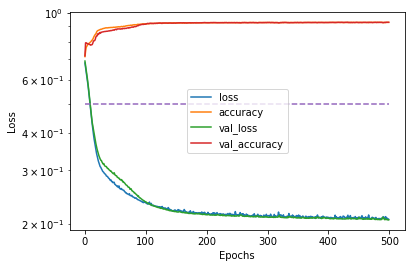

In [46]:
plt.Figure()
for kk in history.history.keys():
    plt.plot(history.history[kk], label=kk)
plt.plot([0,500], [0.5,0.5], '--')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.yscale('log')
plt.show()

In [47]:
from sklearn.metrics import roc_curve

1436/1436 [==============================] - 1s 708us/step


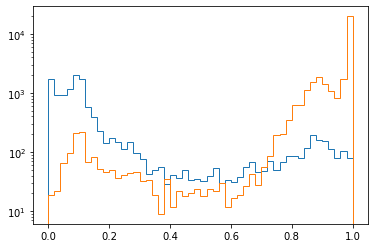

In [48]:
Y_pred = model.predict(X_test, verbose=1).flatten()

plt.Figure()
plt.hist(Y_pred[(N_hit_test>1)&(Y_test==0)], histtype='step', bins=50, range=(0,1))
plt.hist(Y_pred[(N_hit_test>1)&(Y_test==1)], histtype='step', bins=50, range=(0,1))
plt.yscale('log')
plt.show()

plt.show()

<ipython-input-49-ff2292a3e696>:4: RuntimeWarning: divide by zero encountered in true_divide
  plt.semilogy(tpr_mus, 1./fpr_mus)


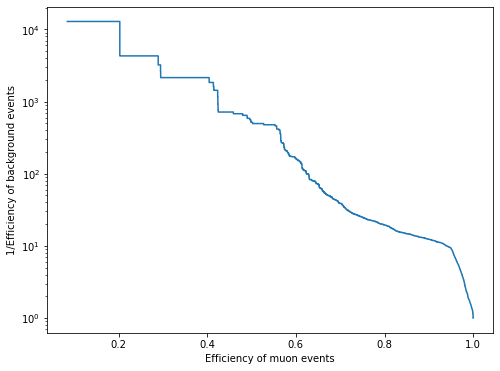

In [49]:
fpr_mus, tpr_mus, _     = roc_curve(Y_test[N_hit_test>1], Y_pred[N_hit_test>1])

plt.figure(figsize=(8,6))
plt.semilogy(tpr_mus, 1./fpr_mus)
# plt.xlim(0.8,1.01)
# plt.ylim(0.5, 1e5)
plt.xlabel('Efficiency of muon events')
plt.ylabel('1/Efficiency of background events')
plt.show()

# 